# MethylScore output filtering 

In [1]:
# import packages 
import os
import awkward as ak
import shutil
import numpy as np 
import pandas as pd 

# 4) Put in categories of hyper- and hypomethylated 

In [2]:
# Define the function to perform the renaming
def rename_based_on_condition(item):
    if item.startswith('A'):
        return 'A'  # Rename if the item starts with A
    elif item.startswith('N'):
        return 'N'  # Rename if the item starts with N
    elif item.startswith('2'):
        return 'R'  # Rename if the item starts with 2


def process_input_file(input_file_path):
    # create result df
    result = pd.DataFrame()
    matched_lines = []

    with open(input_file_path, 'r') as file:
        for i,line in enumerate(file):
            # Split the line into columns
            columns = line.strip().split('\t')

            # Extract the identified clusters column
            clusters = columns[5:-3]
            num_elements = len(clusters)
            half = num_elements // 2
            first_half = clusters[:half]
            last_half = clusters[half:]

            # for last half check put into categories
            last_half = [cluster.split(':')[1] for cluster in last_half]
            last_half = list(map(rename_based_on_condition, last_half))
            
            # for first half 
            first_half = [cluster.split(':')[1] for cluster in first_half]
            # convert lists to dict 
            percentages = {key: [] for key in last_half}
            for condition, percentage in zip(last_half, first_half):
                if percentage == '':
                    continue
                percentages[condition].append(float(percentage))
            percentages = {key: np.mean(value) for key, value in percentages.items()}

            if set(['N','A']) == set(percentages.keys()): 
                ratio = percentages['A'] / percentages['N']
                result['comparison'] = 'AvsN'
            if set(['N','R']) == set(percentages.keys()):
                ratio = percentages['R'] / percentages['N']
                result['comparison'] = 'RvsN'
            if set(['A','R']) == set(percentages.keys()):
                ratio = percentages['R'] / percentages['A']
                result['comparison'] = 'RvsA'
            
            if ratio > 1: 
                result.loc[i, 'methylation_status'] = 'hyper'
            elif ratio < 1: 
                result.loc[i, 'methylation_status'] = 'hypo'                    
            elif ratio == 1: # equal
                result.loc[i, 'methylation_status'] = 'equal'
    return result

# List of input file paths
input_files = ['7_match_dmr_to_gene/dmr_withingene_NvsA.txt', '7_match_dmr_to_gene/dmr_withingene_NvsR.txt', '7_match_dmr_to_gene/dmr_withingene_AvsR.txt']

# Process each input file
results = []
for input_file in input_files:
    results.append(process_input_file(input_file))
results = pd.concat(results)

results['count'] = 1
results = results.groupby(['comparison', 'methylation_status']).sum()

In [3]:
results.reset_index( inplace=True)

In [4]:
results = results.loc[results['methylation_status'] != 'equal']

In [5]:
results

,comparison,methylation_status,count
1,AvsN,hyper,7
2,AvsN,hypo,7
3,RvsA,hyper,1
4,RvsA,hypo,14
5,RvsN,hyper,7
6,RvsN,hypo,21


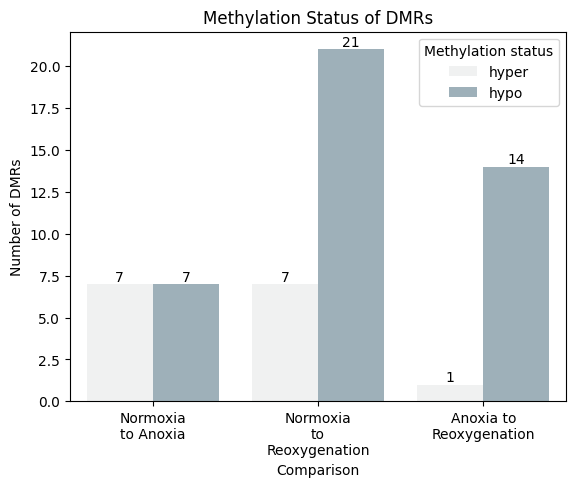

In [6]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)



# create a histogram for each comparison and methylation status 
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.barplot(results, x="comparison",order=['AvsN', 'RvsN','RvsA'] ,  y="count", hue="methylation_status", width=0.8, color="#99B1BD")
for container in ax.containers:
    ax.bar_label(container, fontsize=10)
plt.ylabel('Number of DMRs')
plt.xlabel('Comparison')
plt.title('Methylation Status of DMRs')
plt.legend(title='Methylation status')
ax.set(xticklabels=['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation'])
wrap_labels(ax,10)

plt.savefig('6_DMRsCG/MethylationStatusofDMRs.png', dpi=500, bbox_inches='tight')


